In [1]:
import numpy as np

# Define Network Parameters

In [2]:
binary_dim = 8
input_dim = 2
hidden_dim = 16
output_dim = 1
alpha = 0.1
iteration = 200000
validate_iter = 1000 
accuracy = []
error = []

# Create LookUp Table

In [3]:
largest_num = pow(2, binary_dim)
int2binary = {}#type: dict
binary_array = np.unpackbits(np.array([range(largest_num)], dtype=np.uint8).T, axis=1)
for i, binary in enumerate(binary_array):
    int2binary[i] = binary

# Create Weight Parameters

In [4]:
#U = np.random.uniform(-np.sqrt(1./input_dim), np.sqrt(1./input_dim), (hidden_dim, input_dim))#16x2
#U = 2*np.random.random((hidden_dim, input_dim)) - 1
U = np.random.random((hidden_dim, input_dim)) - 1
#W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))#16x16
#W = 2*np.random.random((hidden_dim, hidden_dim)) - 1
W = np.random.random((hidden_dim, hidden_dim)) - 1
#V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (output_dim, hidden_dim))#1x16
#V = 2*np.random.random((output_dim, hidden_dim)) - 1
V = np.random.random((output_dim, hidden_dim)) - 1

# Build Activation Function and Derivative

In [5]:
def tanh(x):
    return np.atleast_2d(np.tanh(x))
def d_tanh(x):
    return np.diag(np.diag(1-np.matmul(x, x.T)))

def sigmoid(x):
    return 1./(1+np.exp(-x))
def d_sigmoid(x):
    return np.multiply(x, 1.0 - x)

# Train The Network

In [6]:
def train():
    correct_count = 0
    error_count = 0
    for iter in range(1, iteration+1):
        global U, W, V
        #generate inputs
        input_1 = np.random.randint(largest_num/2)
        input_2 = np.random.randint(largest_num/2)
        #convert inputs into binary
        bi_input_1 = int2binary[input_1]
        bi_input_2 = int2binary[input_2]
        #groundtruth
        y_int = input_1 + input_2
        y = np.array(int2binary[y_int], dtype=None)
        #prediction
        y_hat = np.zeros_like(y)
    
        totalError = 0
        output_deltas = list()
        h = list()
        h.append(np.zeros((hidden_dim, 1)))#h[-1] = 0 16x1
        
        #forward propagation
        for pos in range(binary_dim):
            x = np.array([[bi_input_1[binary_dim-pos-1], bi_input_2[binary_dim-pos-1]]]).T # 2x1
            gt = np.array([y[binary_dim-pos-1]])#1x1
            
            #h_t = tanh(W*h_t-1 + U*x_t)
            h_t = tanh(np.dot(W, np.atleast_2d(h[-1])) + np.dot(U, x))#16x16 * 16*1 + 16x2 * 2x1 = 16x1
            #o_t = sigmoid(V*h_t)
            o_t = sigmoid(np.dot(V, h_t))#1x16 * 16x1
            
            output = np.round(o_t[0][0])
            
            loss = o_t - gt
            output_deltas.append(loss*d_sigmoid(o_t))
            
            h.append(h_t)
            y_hat[binary_dim-pos-1] = output
            if output != gt.all():
                #print("output", output)
                #print("gt", gt)
                error_count += 1
        
        next_h = np.zeros((hidden_dim, 1))#h[N+1] = 0 16x1 
        next_h_delta = np.zeros((hidden_dim, 1))#h'[N+1] = 0 16x1
        
        #BPTT
        U_update = np.zeros_like(U)
        V_update = np.zeros_like(V)
        W_update = np.zeros_like(W)
        for pos in range(binary_dim):
            x = np.array([[bi_input_1[pos], bi_input_2[pos]]]).T #2x1
            h_t = h[-pos-1]
            h_t_prev = h[-pos-2]
            output_delta = output_deltas[-pos-1]
            
            #dL/dh_t = dL/do_t * do_t/dh_t + dL/dh_t+1 * dh_t+1/dh_t
            #dL/do_t = output_delta, do_t/dh_t = V.T
            #dL/dh_t+1 = next_h_delta, dh_t+1/dh_t = d_tanh(h_t+1) * W.T
            #16x16 * 16x16 * 16x1 + 16x1 * 1x1
            h_delta = W.T.dot(d_tanh(next_h).dot(next_h_delta)) + V.T.dot(output_delta)
            
            V_update += output_delta.dot(h_t.T)#1x1 * 1x16
            W_update += d_tanh(h_t).dot(h_delta.dot(h_t_prev.T))#16x16 * 16x1 * 1x16
            U_update += d_tanh(h_t).dot(h_delta.dot(x.T))#16x16 * 16x1 * 1x2
            
            next_h = h_t
            next_h_delta = h_delta
            
        U -= U_update * alpha
        W -= W_update * alpha
        V -= V_update * alpha
        
        out = 0
        for index,x in enumerate(reversed(y_hat)):
            out += x*pow(2,index)
        if out == y_int:
            correct_count += 1
        
        if iter % validate_iter == 0:
            out = 0
            for index,x in enumerate(reversed(y_hat)):
                out += x*pow(2,index)
            print("Error:{}".format(error_count))
            print("Accuracy: {}%".format(correct_count/validate_iter*100))
            #print("True:{}".format(y_int))
            #print("x1 + x2 = pred")
            #print("{} + {} = {}".format(input_1, input_2, out))
            print("--------")
            accuracy.append(correct_count/validate_iter*100)
            error.append(error_count)
            correct_count = 0
            error_count = 0

In [7]:
train()

Error:3658
Accuracy: 1.2%
--------
Error:3460
Accuracy: 1.0%
--------
Error:3349
Accuracy: 1.6%
--------
Error:3311
Accuracy: 1.5%
--------
Error:3327
Accuracy: 1.5%
--------
Error:3294
Accuracy: 1.7000000000000002%
--------
Error:3251
Accuracy: 2.1999999999999997%
--------
Error:3194
Accuracy: 2.3%
--------
Error:3263
Accuracy: 2.1%
--------
Error:3237
Accuracy: 1.5%
--------
Error:3300
Accuracy: 1.7999999999999998%
--------
Error:3190
Accuracy: 2.1999999999999997%
--------
Error:3217
Accuracy: 2.0%
--------
Error:3224
Accuracy: 1.3%
--------
Error:3177
Accuracy: 1.7000000000000002%
--------
Error:3162
Accuracy: 2.7%
--------
Error:3206
Accuracy: 3.1%
--------
Error:3214
Accuracy: 2.1999999999999997%
--------
Error:3235
Accuracy: 2.5%
--------
Error:3087
Accuracy: 1.7000000000000002%
--------
Error:3118
Accuracy: 1.5%
--------
Error:3097
Accuracy: 2.1999999999999997%
--------
Error:2999
Accuracy: 2.3%
--------
Error:3091
Accuracy: 2.4%
--------
Error:3013
Accuracy: 3.1%
--------
Error

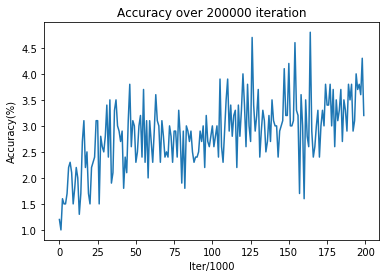

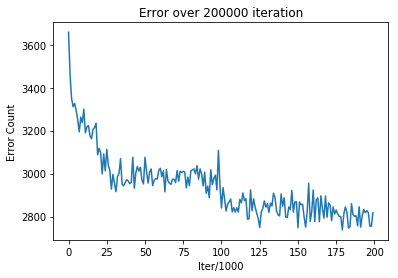

In [9]:
from matplotlib import pyplot as plt
plt.figure()
plt.title("Accuracy over {} iteration".format(iteration))
plt.ylabel("Accuracy(%)")
plt.xlabel("Iter/{}".format(validate_iter))
plt.plot(accuracy)
plt.show()

plt.figure()
plt.title("Error over {} iteration".format(iteration))
plt.ylabel("Error Count")
plt.xlabel("Iter/{}".format(validate_iter))
plt.plot(error)
plt.show()